# Make forward model (Y) with AVISO data

In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
import matplotlib.pyplot as plt

In [2]:
from aviso_rossby_wave import skill_matrix, reverse_vector
from aviso_rossby_wave import make_ssh_predictions, inversion

### parameters

In [3]:
Phi0 = 45 # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
g = 9.81 # gravity 

## Starting Date

In [4]:
day0, day1 = 0, 1

### Stratification paramters

## Subset 10 degree by 10 degree of ocean
### the aviso data is sampled at 5-day intervals

In [5]:
lonidx_west, lonidx_east = 60, 100
latidx_south, latidx_north = 34, 74

In [6]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north, lonidx_west:lonidx_east, :]
T_time = avisso_ds.time.data[day0:] * 86400

In [7]:
date_time = avisso_ds.date_time.data[day0:]
date_time[0]

numpy.datetime64('2016-06-01T00:00:00.000000000')

In [8]:
ssha_time_mean = SSHA.mean(axis = -1)

In [9]:
SSHA = SSHA - SSHA.mean(axis = -1) - SSHA.mean(axis = 0)
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked)

#### MSLA is the AVISO SSH anomalies to fit

In [10]:
MSLA0 = SSHA_masked[:, :, day0:day1]
MSLA0.shape # y_lat, x_lon, t_time

(40, 40, 1)

In [11]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

In [12]:
#### define k, l interval 

In [13]:
L_lat = 10 * 1.11e5
L_lon = 10 * 1.11e5
k_interval = 2 * np.pi / (1.5 * L_lat) # k, l interval
l_interval = 2 * np.pi / (1.5 * L_lon)
# lat
# lon

In [14]:
MModes = 1
k_n_orig = np.arange(2.5e-6, .6e-4, k_interval) #
l_n_orig = np.arange(-.84e-4, .84e-4, l_interval) #
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

In [15]:
strat_ds = xr.open_dataset('./stratification_sample_ccs_2015-01-06.nc')

In [16]:
MModes = 1
Psi = strat_ds.Psi.data
Rm = 6e4 
wavespeed = np.array([Rm * f0])
#wavespeed = strat_ds.C2[:MModes]

#### evalucate the skill of each wave

In [17]:
skill, SSHA_vector, dlon, dlat, Iindex, Jindex, Tindex, Rm = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, wavespeed, lon, lat, T_time)
M = skill.size

100%|████████████████████████████████████████| 720/720 [00:03<00:00, 216.56it/s]


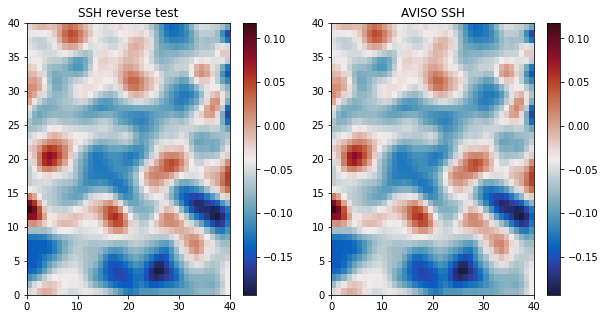

In [18]:
ssha_inverse = reverse_vector(MSLA0, SSHA_vector)
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.title('SSH reverse test')
plt.pcolormesh(ssha_inverse[:, :, 0], cmap = cmo.cm.balance)
plt.colorbar()
plt.subplot(122)
plt.title('AVISO SSH')
plt.pcolormesh(MSLA0[:, :, 0], cmap = cmo.cm.balance)
plt.colorbar()

#### Signal to noise ratio matrix

In [19]:
P_over_R = np.eye(2 * M, 2 * M)
    
for ii in range(2 * M):    
    P_over_R[ii, ii] = 0.002

#### Build basis function H matrix

In [20]:
MModes = 1
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M*2])
freq_n = np.zeros([M, MModes])

count = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            freq_n[count, mm] =  -1 * (Beta * k_n[kk]) / (k_n[kk] ** 2 + l_n[ll] ** 2 + Rm ** (-2))
            count += 1

In [21]:
nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            for count in range(len(Iindex)):
                H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk] * dlon[int(Iindex[count])]* 1.11e5 + l_n[ll] * dlat[int(Jindex[count])]* .85e5 - freq_n[nn] * T_time[int(Tindex[count])])  
                H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk] * dlon[int(Iindex[count])]* 1.11e5 + l_n[ll] * dlat[int(Jindex[count])]* .85e5 - freq_n[nn] * T_time[int(Tindex[count])])
            nn += 1

In [22]:
H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

#### solve for amplitudes

In [23]:
amp, ssh_estimated = inversion(SSHA_vector, H_all, P_over_R)

In [26]:
make_ssh_predictions?

Signature: make_ssh_predictions(timestamp, amp, MSLA, H_matrix)
Docstring:
Make SSH predictions with the estimated Rossby wave amplutudes.
Imput: timestamp, estimated amplitudes, True AVISO SSH anomalies and H matrix (basis functions).
File:      ~/Desktop/SWOT/CER/swot-cer/aviso_rossby_wave.py
Type:      function


In [28]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA0.size])
SSHA_true = np.zeros([time_range, MSLA0.size])
variance_explained_inverse = np.zeros(time_range)
MSLA_fwrd = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(time_range):
    MSLA = SSHA_masked[:,:,day0 + day:day0 + day + 1]
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = make_ssh_predictions(day, amp, MSLA, H_all)
    MSLA_fwrd[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])

In [29]:
ds_output = xr.Dataset(data_vars={'k_n' : k_n[:, 0],
                                  'l_n' : l_n[:, 0],
                                  'Amplitudes': amp,
                                  'variance_explained': (('time'), variance_explained_inverse),
                                  'MSLA_forward' : (('YC', 'XC', 'time'), MSLA_fwrd[:, :, :time_range]),
                                  'XC' : (('XC'), lon.data), 
                                  'YC' : (('YC'), lat.data),
                                  'time': date_time[day:day+time_range]},
                      attrs = dict(description=('Data sample of the selected waves, amplitudes, estimated SSH anomalies and residual.')))

In [30]:
ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(l_n.size * k_n.size) +'waves.nc')

### Plot the Rossby wave model versus the AVISO data

In [31]:
selected_lat = 20
selected_time = 8 # 5 * 8 = 40 days
time = T_time[:selected_time]/86400
SSHA[selected_lat, :, :selected_time].shape

(40, 8)

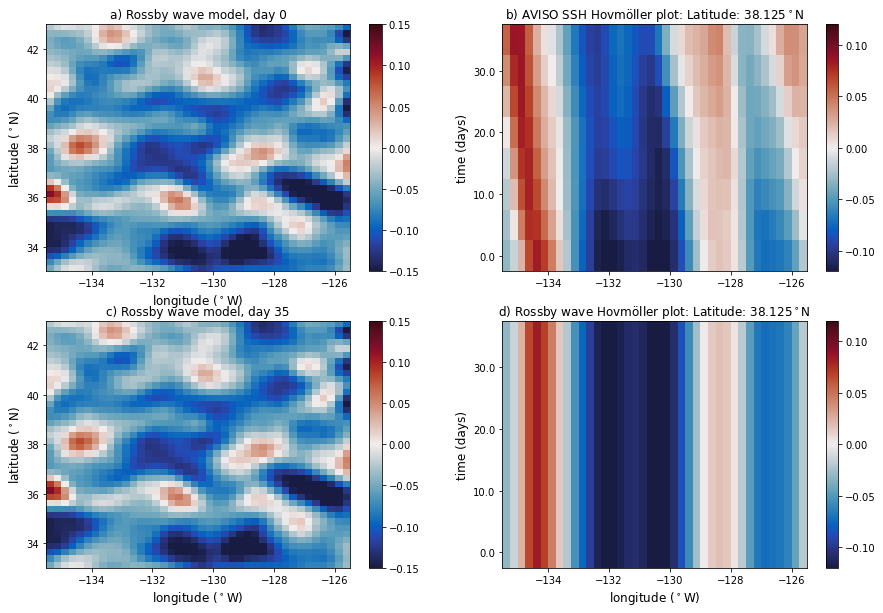

In [32]:
date1, date2 = 0, 7
plt.figure(figsize = (15, 10))
plt.subplot(221) 
plt.title('a) Rossby wave model, day '+ str(int(date1 * 5)))
plt.pcolormesh(lon, lat,  MSLA_fwrd[:, :, date1], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('latitude ($^\circ$N)', fontsize = 12)
#plt.subplot(222) 
#plt.title('b) AVISO SSH, day '+ str(int(date1 * 5)))
#plt.pcolormesh(lon, lat,  SSHA[:, :, day0 + date1], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#plt.colorbar()

plt.subplot(222) 
#plt.subplot(311)
plt.title('b) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time,  SSHA[selected_lat, :, :selected_time].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.colorbar()
#plt.xlabel('longitude ($^\circ$W)', fontsize = 14)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])

plt.subplot(223) 
plt.title('c) Rossby wave model, day ' + str(int(date2 * 5)))
plt.pcolormesh(lon, lat,  MSLA_fwrd[:, :, date2], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('latitude ($^\circ$N)', fontsize = 12)

plt.subplot(224) 
#plt.subplot(311)
plt.title('d) Rossby wave Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :selected_time].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])

#plt.title('a) Rossby wave model, difference')
#plt.pcolormesh(lon, lat, ds_output.MSLA_forward[:, :, date2] - ds_output.MSLA_forward[:, :, date1], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#plt.colorbar()
plt.savefig('fwrd_model' + str(l_n.size * k_n.size) + 'waves.png')

In [33]:
selected_lat = 30

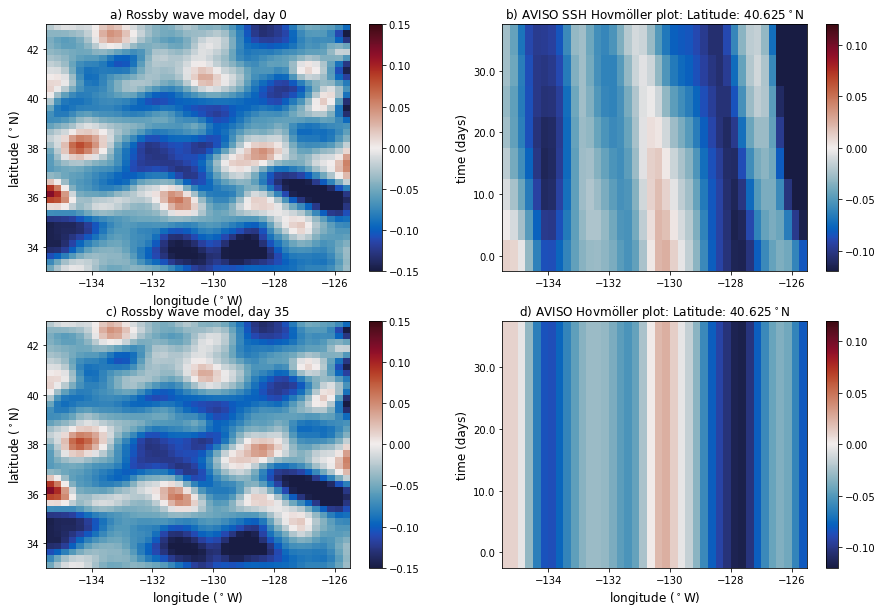

In [34]:
date1, date2 = 0, 7
plt.figure(figsize = (15, 10))
plt.subplot(221) 
plt.title('a) Rossby wave model, day '+ str(int(date1 * 5)))
plt.pcolormesh(lon, lat,  MSLA_fwrd[:, :, date1], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('latitude ($^\circ$N)', fontsize = 12)
#plt.subplot(222) 
#plt.title('b) AVISO SSH, day '+ str(int(date1 * 5)))
#plt.pcolormesh(lon, lat,  SSHA[:, :, day0 + date1], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#plt.colorbar()

plt.subplot(222) 
#plt.subplot(311)
plt.title('b) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time,  SSHA[selected_lat, :, :selected_time].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.colorbar()
#plt.xlabel('longitude ($^\circ$W)', fontsize = 14)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])

plt.subplot(223) 
plt.title('c) Rossby wave model, day ' + str(int(date2 * 5)))
plt.pcolormesh(lon, lat,  MSLA_fwrd[:, :, date2], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('latitude ($^\circ$N)', fontsize = 12)

plt.subplot(224) 
#plt.subplot(311)
plt.title('d) AVISO Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :selected_time].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])

#plt.title('a) Rossby wave model, difference')
#plt.pcolormesh(lon, lat, ds_output.MSLA_forward[:, :, date2] - ds_output.MSLA_forward[:, :, date1], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#plt.colorbar()
plt.savefig('fwrd_model' + str(l_n.size * k_n.size) + 'waves.png')